In [50]:
import pandas as pd
import numpy as np
import tensorflow as tf
from math import sqrt
from math import pi
from math import exp

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import graphviz
import pydot

from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

if tf.__version__.startswith("2."):
    import tensorflow.compat.v1 as tf
    tf.compat.v1.disable_v2_behavior()
    tf.compat.v1.disable_eager_execution()

In [51]:
dfTitanic = pd.read_csv('data_titanic_proyecto.csv')
dfTitanic = dfTitanic.drop(["PassengerId", "Name", "Cabin", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"], axis = 1)

dfTitanic["passenger_sex"] = dfTitanic["passenger_sex"].map({'M': 0, 'F': 1}).astype(int)
dfTitanic["passenger_survived"] = dfTitanic["passenger_survived"].map({'N': 0, 'Y': 1}).astype(int)
dfTitanic["passenger_class"] = dfTitanic["passenger_class"].map( {'Lower': 0, 'Middle': 1,'Upper':2}).astype(int)

dfTitanic.head()

,Age,passenger_class,passenger_sex,passenger_survived
0,22.0,0,0,0
1,38.0,2,1,1
2,26.0,0,1,1
3,35.0,2,1,1
4,35.0,0,0,0


In [52]:
imputer = KNNImputer()
dfTitanicFilled = imputer.fit_transform(dfTitanic)
dfTitanic["Age"] = dfTitanicFilled[:,0]

# dfTitanic.loc[dfTitanic['Age'] <= 5, 'Age'] = 0
# dfTitanic.loc[(dfTitanic['Age'] > 5) & (dfTitanic['Age'] <= 10), 'Age'] = 1
# dfTitanic.loc[(dfTitanic['Age'] > 10) & (dfTitanic['Age'] <= 15), 'Age'] = 2
# dfTitanic.loc[(dfTitanic['Age'] > 15) & (dfTitanic['Age'] <= 20), 'Age'] = 3
# dfTitanic.loc[(dfTitanic['Age'] > 20) & (dfTitanic['Age'] <= 25), 'Age'] = 4
# dfTitanic.loc[(dfTitanic['Age'] > 25) & (dfTitanic['Age'] <= 30), 'Age'] = 5
# dfTitanic.loc[(dfTitanic['Age'] > 30) & (dfTitanic['Age'] <= 35), 'Age'] = 7
# dfTitanic.loc[(dfTitanic['Age'] > 35) & (dfTitanic['Age'] <= 40), 'Age'] = 8
# dfTitanic.loc[(dfTitanic['Age'] > 40) & (dfTitanic['Age'] <= 45), 'Age'] = 8
# dfTitanic.loc[(dfTitanic['Age'] > 45) & (dfTitanic['Age'] <= 50), 'Age'] = 9
# dfTitanic.loc[ dfTitanic['Age'] > 50, 'Age'] = 10

In [53]:
trainData, testData = train_test_split(dfTitanic, test_size = 0.2)
trainData, validationData = train_test_split(trainData, test_size = 0.2)

## Feature Engineering 

,Age,passenger_class,passenger_sex,passenger_survived
0,-0.148023,0.339796,0.528803,1.0


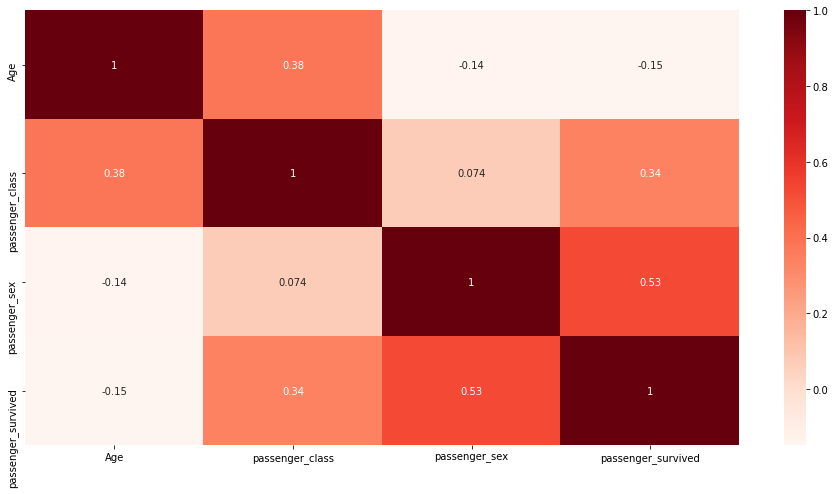

In [54]:
corr = trainData.corrwith(trainData["passenger_survived"])

plt.figure(figsize=(16, 8))
sns.heatmap(trainData.corr(), cmap="Reds", annot=True)

corr.to_frame().T

## Naive Bayes

In [66]:
def naiveBayes(df, yLabel, xPredict):
    n = df[yLabel].shape[0]
    nPredict = xPredict.shape[0]
    yUnique = df[yLabel].unique()

    means = df.groupby(yLabel).mean()
    stds = df.groupby(yLabel).std()

    classProbabilities = df.groupby(yLabel).apply(lambda x: len(x)) / n

    probabilities = np.zeros((len(yUnique), nPredict))
    for class_ in yUnique:
        mean = means.iloc[class_].to_numpy()
        std = stds.iloc[class_].to_numpy()

        varsProbabilities = (1 / (sqrt(2 * np.pi) * std)) * np.exp(-((xPredict - mean) ** 2 / (2 * std ** 2)))
        probabilities[class_] = classProbabilities[class_] * np.product(varsProbabilities, axis = 1)

    return np.argmax(probabilities.T, axis = 1)

In [87]:
xTest = validationData[["passenger_sex"]].to_numpy()
yTest = validationData["passenger_survived"].to_numpy()

xTrain = trainData[["passenger_sex", "passenger_survived"]]

yPredict = naiveBayes(xTrain, "passenger_survived", xTest)

yPredict

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0])

In [88]:
    accuracy_score(yTest, yPredict)

0.7832167832167832

## Decision Tree

In [90]:
tree = DecisionTreeClassifier()
tree = tree.fit(xTrain[["passenger_sex"]], xTrain[["passenger_survived"]])
yTree = tree.predict(xTest)

yTree

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0])

In [91]:
accuracy_score(yTest, yTree)

0.7832167832167832

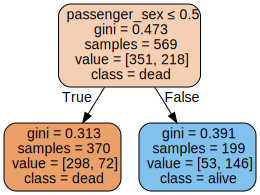

In [93]:
dot_data = export_graphviz(tree, out_file=None,
                                        feature_names=["passenger_sex"],
                                        class_names=["dead", "alive"],
                                        filled=True, rounded=True,
                                        special_characters=True)
graph = graphviz.Source(dot_data)
graph

## SVM

In [94]:
svm = SVC(kernel = 'linear')

# svm = svm.fit(df[["weather_encoded", "temp_encoded"]], df['Y'])
# ySvm = svm.predict(x_test)
svm = svm.fit(xTrain[["passenger_sex"]], xTrain[["passenger_survived"]])
ySvm = tree.predict(xTest)

ySvm

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0])

In [95]:
accuracy_score(yTest, ySvm)

0.7832167832167832

In [100]:
def logisticRegression(x, y, epochs, lr, batchSize, regularization, beta, modelName, printRate):
    tf.reset_default_graph()
    
    n = x.shape[0]

    totalIterations = int(n / batchSize)
    x = np.hstack((x, np.ones((n, 1))))
    y = y.reshape(-1, 1)

    vars_ = x.shape[1]

    with tf.name_scope("intup"):
        xTrain = tf.placeholder(tf.float32, [batchSize, vars_], "x")
        yTrain = tf.placeholder(tf.float32, [batchSize, 1], "y")
    with tf.name_scope("params"):
        params = tf.Variable(name = "params", initial_value = tf.zeros(([vars_, 1]), dtype = tf.float32))
    with tf.name_scope("logits"):
        logits = tf.matmul(xTrain, params)
    with tf.name_scope("loss"):
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits, labels = yTrain))
    with tf.name_scope("gradient"):
        gradients = tf.gradients(loss, params)
    with tf.name_scope("model"):
        fit = tf.scalar_mul(-lr, gradients[0])
        model = tf.assign(params, tf.add(params, fit))


    with tf.Session() as session:
        writer = tf.summary.FileWriter("./" + modelName + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "_lr=" + str(lr) + "_epochs=" + str(epochs), session.graph)
        session.run(tf.global_variables_initializer())
        
        for epoch in range(epochs):
            for i in range(totalIterations):
                start = i * batchSize
                end = start + batchSize
                
                x_ = np.array(x[start:end])
                y_ = np.array(y[start:end])
                
                feedDict = {xTrain: x_, yTrain: y_}
                session.run(model, feed_dict = feedDict)

            if ((epoch + 1) % printRate) == 0:
                print("error: " + str(session.run(loss, feed_dict = feedDict)))
      
            #writer.add_summary(session.run(summary), epoch)

        params = session.run(params)

        writer.close()
    session.close()

    return params

In [101]:
coeficients = logisticRegression(x = xTrain[["passenger_sex"]].to_numpy(), y = xTrain[["passenger_survived"]].to_numpy(), epochs = 3000, lr = 0.2, batchSize = 8, regularization = 0, beta = 0, modelName = "titanic", printRate = 1000)
coeficients

error: 1.1962279
error: 1.1962279
error: 1.1962279


array([[ 2.4637177],
       [-1.313284 ]], dtype=float32)

In [112]:
def predictLogisticRegression(x, coeficients):
    tf.reset_default_graph()
    
    x = np.hstack((x, np.ones((x.shape[0], 1))))
    x_ = tf.placeholder(tf.float32, [x.shape[0], None], "x")
    
    with tf.Session() as session:
        prediction = session.run(tf.cast(tf.nn.sigmoid(tf.matmul(x_, coeficients)) > 0.5, tf.int32), feed_dict={x_: x})
        
        session.close()
    return prediction

In [113]:
yLogistic = predictLogisticRegression(xTest, coeficients)

In [114]:
accuracy_score(yTest, yLogistic)

0.7832167832167832